# Como lake: Daily dataset exploration
The dataset provided by the researchers of PoliMi contains the daily *Levels* (in $cm$), *Inflows* (in $m^3/s$) and *Releases* (in $m^3/s$) of the Como lake from 1946 to 2011. More recent values can be found at this [link](https://adda.laghi.net/homepage.aspx?tab=3&subtab=2&idlago=1). This notebook will be used to explore the dataset and to study the process that produces the inflows values.

Let's start by importing the libraries thatwill be used and the dataset, we will also add a new column containing the complete datetime of each entry:

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

from fbprophet import Prophet
import fbprophet.plot as fbp
import scipy.stats 

# Import the dataset 
df = pd.read_csv('data/como_data_1946_2011.txt', sep="  ", engine='python')
df['date'] = pd.to_datetime(df[["year", "month", "day"]])
df

,day,month,year,level,release,inflow,date
0,1.0,1.0,1946.0,1.150,116.00,65.6,1946-01-01
1,2.0,1.0,1946.0,1.120,93.00,93.0,1946-01-02
2,3.0,1.0,1946.0,1.120,84.00,67.2,1946-01-03
3,4.0,1.0,1946.0,1.110,84.00,33.6,1946-01-04
4,5.0,1.0,1946.0,1.080,84.00,84.0,1946-01-05
...,...,...,...,...,...,...,...
23979,27.0,8.0,2011.0,0.355,196.21,204.6,2011-08-27
23980,28.0,8.0,2011.0,0.360,194.42,102.1,2011-08-28
23981,29.0,8.0,2011.0,0.305,194.19,160.6,2011-08-29
23982,30.0,8.0,2011.0,0.285,189.73,72.3,2011-08-30


# Inflow modelling
Let's start by plotting a portion of the inflow time series. We will take a look at one of the last available years to check that the data is the same than the one available online [here](https://adda.laghi.net/homepage.aspx?tab=3&subtab=2&idlago=1).

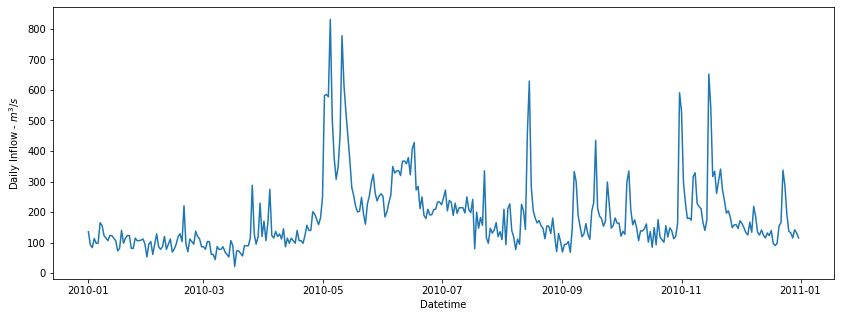

In [41]:
# Plot sequence of inflows of the last full year
plt.figure(figsize=(14,5))
plt.plot(df.date[df.year==2010], df.inflow[df.year==2010])
plt.xlabel('Datetime')
plt.ylabel('Daily Inflow - '+r'$m^3/s$')
plt.show()

We already know that there is seasonality, we will repeat the seasonal decomposition of the weekly analysis to obtain the seasonal component using the Prophet libary. Differently from the other analysis, here we also have many more years, thus we will also study the non stationary behavior that the trend will present.

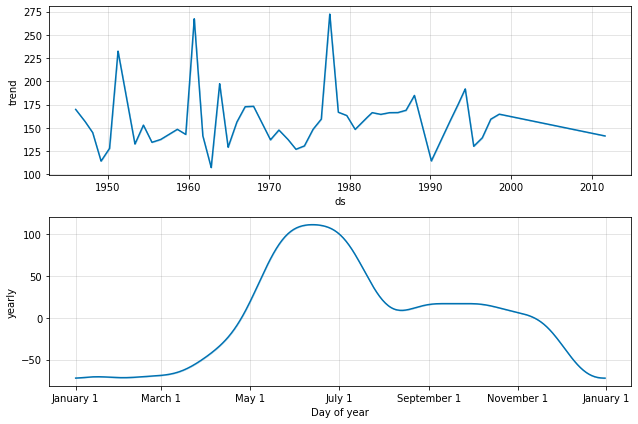

In [55]:
# format data to be compatible with the library
inflow = df[['date','inflow']]
inflow.columns = ['ds','y']

# Find seasonality (fit it using fourier series of given order)
model = Prophet(yearly_seasonality = 8, 
                weekly_seasonality = False,
                daily_seasonality  = False,
                n_changepoints = 50,
                changepoint_prior_scale=0.5)
model.fit(inflow)

# Build estimated inflows
inflow_estim = model.predict()

# Plot fitted components
model.plot_components(inflow_estim)
plt.show()

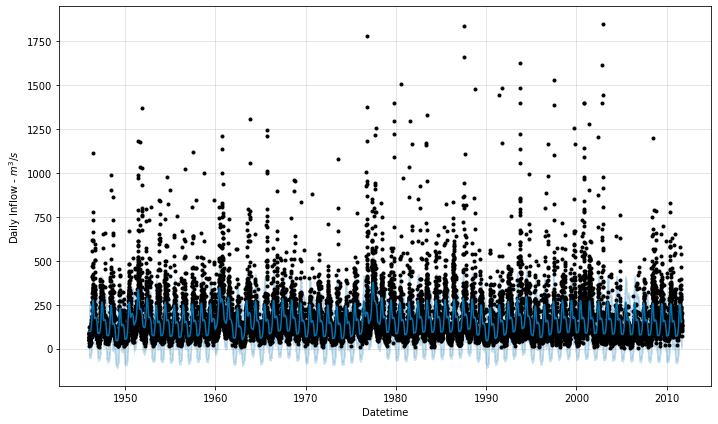

In [57]:
# Plot few years of the estimated inflow
model.plot(inflow_estim)
plt.xlabel('Datetime')
plt.ylabel('Daily Inflow - '+r'$m^3/s$')
#plt.xlim((0,2000))
#plt.ylim(-100,800)
plt.show()